<a href="https://colab.research.google.com/github/FlyingWorkshop/DiffusionGNNTutorial/blob/main/simple_edm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [4]:
!pip install torch_geometric
!pip install rdkit

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from scipy.spatial.transform import Rotation
import numpy as np

from torch_geometric.datasets import QM9
from rdkit import Chem

from mpl_toolkits.mplot3d.art3d import Line3DCollection
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

from collections import namedtuple
from PIL import Image
from IPython.display import HTML
import io

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Hard Example

Data(x=[16, 11], edge_index=[2, 40], edge_attr=[40, 4], y=[1, 19], pos=[16, 3], z=[16], smiles='[H]C1([H])[N@H+]2[C@@]3([H])[C@@]14O[C@@]1([H])[C@@]([H])([C@]24[H])[C@]13[H]', name='gdb_133885', idx=[1])


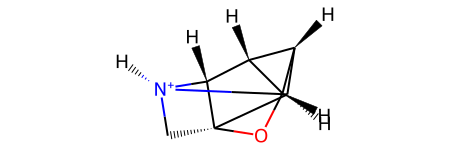

In [3]:
# load QM9 dataset
# documentation: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html?highlight=qm9#torch_geometric.datasets.QM9
dataset = QM9(root='drive/MyDrive/Tutorial/data/QM9/')
ex_hard = dataset[-1]
print(ex_hard)
mol = Chem.MolFromSmiles(ex_hard.smiles)
mol

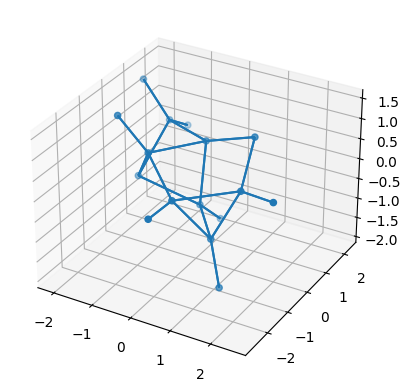

In [6]:
def plot_molecule(example):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  # draw nodes
  pos = example.pos
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2])

  # draw edges
  edge_index = example.edge_index
  starts = pos[edge_index[0].detach().numpy()]
  stops = pos[edge_index[1].detach().numpy()]
  lines = torch.hstack((starts, stops)).reshape((-1, 2, 3))
  ax.add_collection(Line3DCollection(lines))

plot_molecule(ex_hard)

## Medium Example

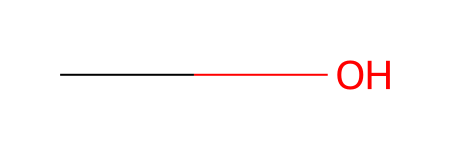

In [285]:
ex_medium = dataset[7]
mol = Chem.MolFromSmiles(ex_medium.smiles)
mol

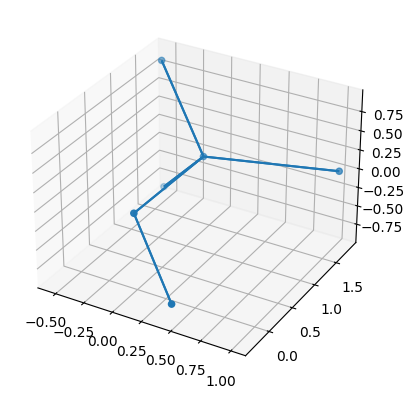

In [286]:
plot_molecule(ex_medium)

## Easy Example

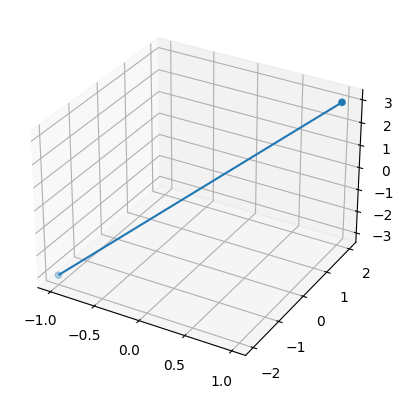

In [190]:
Example = namedtuple('Example', ['pos', 'edge_index'])
ex_easy = Example(torch.Tensor([[-1, -2, -3], [1, 2, 3]]), torch.Tensor([[0], [1]]))
plot_molecule(ex_easy)

In [240]:
def calc_rmsd(coords_a, coords_b):
    """
    Adapted from Martin Buttenschoen.
    Calculate RMSD assuming that the atom positions are ordered appropriately.
    """
    assert coords_a.shape == coords_b.shape
    coords_a, coords_b = transform(coords_a, coords_b)
    return (((coords_a - coords_b) ** 2).mean() * coords_a.shape[-1]).sqrt()


def transform(target, ref):
  # remove centroid
  target = target - torch.mean(target, dim=0, keepdim=True)
  ref = ref - torch.mean(ref, dim=0, keepdim=True)

  # rotate
  R, _ = Rotation.align_vectors(target, ref)
  target = torch.Tensor(R.apply(target))

  return target, ref

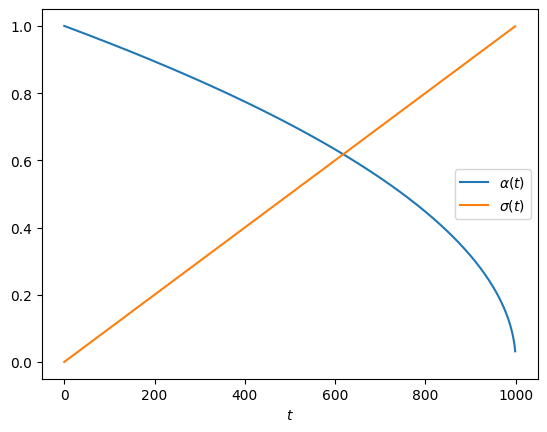

In [319]:
class SimpleEGCL(nn.Module):
  def __init__(self, hidden=32):
    """Noise prediction layer used to parameterize the denoising model"""
    super().__init__()
    self.mlp = nn.Sequential(
        nn.Linear(1, hidden),
        nn.SiLU(),
        nn.Linear(hidden, 1, bias=False)
    )

    for layer in self.mlp:
      if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)

  def forward(self, z, epsilon=1e-3):
    """
    Input is a noisy latent representation of the coordinates. Since this is
    a GNN, we the latent representation has the same dimensions as the true
    point cloud. This particular layer is also equivariant (adapted from
    the E(n) layers).

    The output is the predicted noise that the model infers was added
    to some true latent representation of the coordinates which we obtain
    by subtracting our predicted true latent representation from the given
    noisy one.
    """
    diffs = z - z.unsqueeze(1)
    dists = torch.norm(diffs, dim=-1, keepdim=True)
    normalized = diffs / (dists + epsilon)
    batched_dists = dists.ravel().unsqueeze(-1)
    weights = self.mlp(batched_dists).reshape_as(dists)
    pred_z = z + torch.sum(normalized * weights, dim=0)
    return pred_z


class SimpleEGNN(nn.Module):
  def __init__(self, num_layers=4, hidden=32):
    """Denoising model"""
    super().__init__()
    self.layers = nn.ModuleList([SimpleEGCL(hidden=hidden) for _ in range(num_layers)])

  def forward(self, z):
    pred_z = z
    for layer in self.layers:
      pred_z = layer(pred_z)
    pred_noise = pred_z - z
    centroid = torch.mean(pred_noise, dim=0, keepdim=True)  # subtract center of gravity
    return pred_noise - centroid


class SimpleEDM:
  def __init__(self, num_layers=1, hidden=32, max_timesteps=1000, lr=1e-3):
    self.model = SimpleEGNN(num_layers, hidden=hidden)
    self.mse = nn.MSELoss()
    self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    self.max_timesteps = max_timesteps
    self.normal_dist = torch.distributions.MultivariateNormal(torch.zeros(3), torch.eye(3))
    self.uniform_dist = torch.distributions.Uniform(low=0, high=max_timesteps)

  def alpha(self, t):
    return np.sqrt(1 - self.sigma(t))

  def sigma(self, t, epsilon=1e-3):
    return t / (self.max_timesteps + epsilon)

  def plot_alpha_and_sigma(self):
    domain = np.arange(self.max_timesteps)
    plt.plot(domain, self.alpha(domain), label=r"$\alpha(t)$")
    plt.plot(domain, self.sigma(domain), label=r"$\sigma(t)$")
    plt.xlabel("$t$")
    plt.legend()

  def sample_noise(self, n):
    noise = self.normal_dist.sample(sample_shape=(n,))  # noise.shape = (n, 3)
    noise -= torch.mean(noise, dim=0, keepdim=True)
    return noise

  def encoder(self, x, t, noise):
    """
    NOTE: forward step in diffusion process; uses 'reparam trick'
    to make expression deterministic WRT to x and thus diff'able
    so grads can prop. W/O this parameterization, z would be
    drawn from q(z_t|x). Since z would then be a stochastic sample,
    it wouldn't be differentiable and we wouldn't be able to use
    grad descent.
    """
    z = self.alpha(t) * x + self.sigma(t) * noise
    return z

  def decoder(self, z, t, noise):
    """
    See Kingma paper 'Variational Diffusion Models' equation (10)
    and Hoogeboom paper equation (16).
    """
    x = (z - self.sigma(t) * noise) / self.alpha(t)
    return x

  def optimize(self, example, epochs=100):
    """
    In this toy example, our SimpleEDM's optimization tries to
    overfit on the positional information of a single example.
    """
    history = {k: [] for k in ("mse", "rmsd")}

    x = example.pos
    n = x.shape[0]
    for i, t in tqdm(enumerate(self.uniform_dist.sample(sample_shape=(epochs,))), total=epochs):
      self.optimizer.zero_grad()
      noise = self.sample_noise(n)
      z = self.encoder(x, t, noise)  # noisy latent representation
      pred_noise = self.model(z)

      # MSE
      loss = self.mse(pred_noise, noise)
      loss.backward()
      self.optimizer.step()
      history["mse"].append(loss.detach().numpy())

      # RMSD
      with torch.no_grad():
        pred_x = self.decoder(z, t, pred_noise)
        rmsd = calc_rmsd(pred_x, x)
        history["rmsd"].append(rmsd)

    return history

  def forward_diffuse(self, example):
    x = example.pos
    n = x.shape[0]
    noise = self.sample_noise(n)
    return self.encoder(x, self.max_timesteps, noise)

  def _calc_alphas(self, t, s):
    """Helper for sample"""
    return {
        "t|s": self.alpha(t) / self.alpha(s)
    }

  def _calc_sigmas(self, t, s, alpha):
    """Helper for sample"""
    sigma_t = self.sigma(t)
    sigma_s = self.sigma(s)
    sigma = {
        "squared_t|s": sigma_t ** 2 - (alpha["t|s"] * sigma_s) ** 2,
        "t": sigma_t,
    }
    sigma["t->s"] = np.sqrt(sigma["squared_t|s"]) * sigma_s / sigma_t  # Bayes
    return sigma

  def sample(self, n: int, deterministic=True):
    history = []
    with torch.no_grad():
      z_t = self.normal_dist.sample(sample_shape=(n,))
      for t in range(self.max_timesteps, 1, -1):
        # predict noise and x
        pred_noise = self.model(z_t)
        pred_x = self.decoder(z_t, t, pred_noise)

        # update history
        history.append(pred_x)

        # apply reparam trick to get z_s
        s = t - 1
        alpha = self._calc_alphas(t, s)
        sigma = self._calc_sigmas(t, s, alpha)
        mean = (
            (1 / alpha["t|s"]) * z_t
            - (sigma["squared_t|s"] / (alpha["t|s"] * sigma["t"])) * pred_noise
        )
        if deterministic:
          z_s = mean + sigma["t->s"] * self.sample_noise(n)
        else:
          z_s = mean + sigma["t->s"] * pred_noise

        # update z_t
        z_t = z_s

    return history

  def reverse_diffuse(self):
    with torch.no_grad():
      z = self.normal_dist.sample(sample_shape=(n,))
      pred_noise = self.model(z)
      x = self.decoder(z, self.max_timesteps, pred_noise)
      return x

edm = SimpleEDM(num_layers=4, max_timesteps=1000, hidden=32)
edm.plot_alpha_and_sigma()

# Forward Difussion (Optimization)

In [320]:
working_example = ex_medium

  0%|          | 0/1000 [00:00<?, ?it/s]

min_loss=0.013706829398870468
min_rmsd=0.0014030943857505918


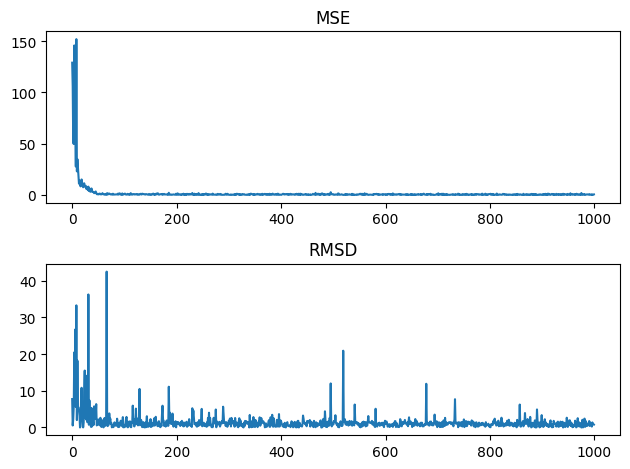

In [321]:
epochs = 1000
optimize_history = edm.optimize(working_example, epochs=epochs)

min_loss = float(min(optimize_history["mse"]))
min_rmsd = float(min(optimize_history["rmsd"]))
print(f"{min_loss=}")
print(f"{min_rmsd=}")

fig, axs = plt.subplots(2, 1)
domain = range(epochs)
axs[0].plot(domain, optimize_history["mse"])
axs[0].set_title("MSE")
axs[1].plot(domain, optimize_history["rmsd"])
axs[1].set_title("RMSD")
fig.tight_layout()

# Reverse Process (Sampling)

  0%|          | 0/999 [00:00<?, ?it/s]

max_rmsd=1002.307861328125
min_rmsd=3.176781415939331


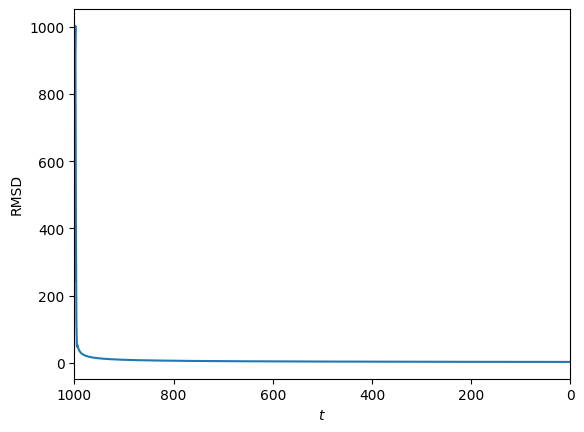

In [333]:
x = working_example.pos
n = x.shape[0]
sample_history = edm.sample(n, deterministic=False)
rmsd_history = [calc_rmsd(pred_x, x) for pred_x in tqdm(sample_history)]

max_rmsd = float(max(rmsd_history).numpy())
min_rmsd = float(min(rmsd_history).numpy())
print(f"{max_rmsd=}")
print(f"{min_rmsd=}")

plt.xlim(edm.max_timesteps, 0)
plt.plot(range(edm.max_timesteps, 1, -1), rmsd_history)
plt.ylabel("RMSD")
plt.xlabel("$t$")
plt.show()

RMSD: 3.0518475


(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

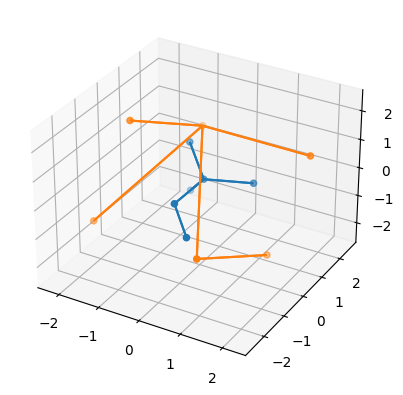

In [334]:
def plot_molecules(example, pred_pos, show=False, verbose=False):
  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')

  pred_pos, pos = transform(pred_pos, example.pos)
  if verbose:
    print("RMSD:", calc_rmsd(pred_pos, pos).numpy())
  pred_pos = pred_pos.numpy()
  pos = pos.numpy()

  # draw nodes
  ax.scatter(pos[:, 0], pos[:, 1], pos[:, 2], c="C0")
  ax.scatter(pred_pos[:, 0], pred_pos[:, 1], pred_pos[:, 2], c="C1")

  # reorder coords and edges
  sorted_indices = np.argsort(pos[:, 0])
  pos = pos[sorted_indices]
  pred_pos = pred_pos[np.argsort(pred_pos[:, 0])]
  replacements = {j: i for i, j in enumerate(sorted_indices)}
  edge_index = np.vectorize(replacements.get)(example.edge_index)

  # draw edges
  for i, x in enumerate((pos, pred_pos)):
    starts = x[edge_index[0]]
    stops = x[edge_index[1]]
    lines = np.hstack((starts, stops)).reshape((-1, 2, 3))
    ax.add_collection(Line3DCollection(lines, color=f"C{i}"))

  return fig, ax

plot_molecules(working_example, sample_history[-1], show=True, verbose=True)

(<Figure size 640x480 with 1 Axes>, <Axes3D: >)

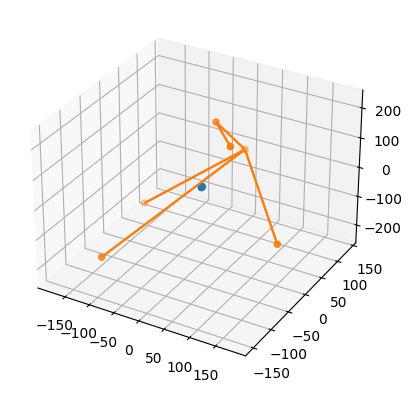

In [340]:
# The naive reverse diffusion takes no steps and should perform much worse!
plot_molecules(working_example, edm.reverse_diffuse())

In [341]:
def fig2img(fig):
    """
    Adapted from: https://stackoverflow.com/a/61754995/15001799
    Convert a Matplotlib figure to a PIL Image and return it
    """
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img

def animate_reverse_diffusion(example, history, save_path="drive/MyDrive/Tutorial/reverse_diffusion.gif"):
  frames = []
  for pred_pos in tqdm(history):
    fig, ax = plot_molecules(example, pred_pos)
    frames.append(fig2img(fig))
    plt.close()
  frames[0].save(save_path, save_all=True, append_images=frames[1:], duration=60, loop=0, optimize=True, quality=20)

animate_reverse_diffusion(working_example, sample_history)

  0%|          | 0/999 [00:00<?, ?it/s]